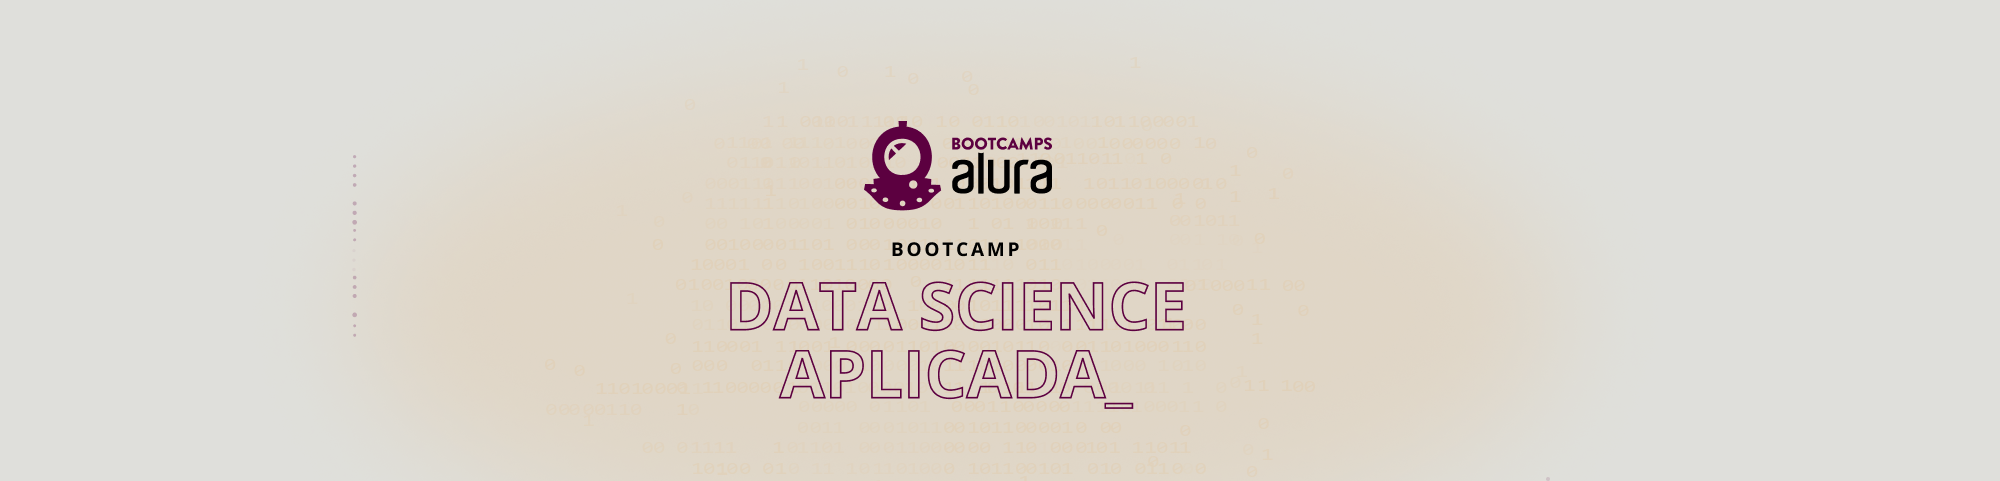

# **Module 03**

Análise de séries temporais de dados do COVID-19, extraídos do [site do Governo do Estado de São Paulo](https://www.seade.gov.br/coronavirus/), usando o Facebook Prophet.

# **Presettings**

In [239]:
# Imports do primeiro capítulo
import pandas as pd
from pandas.plotting import autocorrelation_plot

import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np

# Imports do segundo capítulo
from fbprophet import Prophet
''' O fp antes do prophet é só necessário no google colab, em outras IDEs não é necessário '''

' O fp antes do prophet é só necessário no google colab, em outras IDEs não é necessário '

In [240]:
# removing warnings
import warnings
warnings.filterwarnings('ignore')

#setting charts style
# sns.set()

# setting graph parametters
mpl.rcParams['font.size'] = 18
mpl.rcParams['figure.figsize'] = (12,8)

In [241]:
url = 'https://github.com/alura-cursos/Prophet_covid/blob/main/dados_covid_sp.zip?raw=true'
dados = pd.read_csv(url, sep = ';', compression='zip')
dados.head()

,nome_munic,codigo_ibge,dia,mes,datahora,casos,casos_novos,casos_pc,casos_mm7d,obitos,obitos_novos,obitos_pc,obitos_mm7d,letalidade,nome_ra,cod_ra,nome_drs,cod_drs,pop,pop_60,area,map_leg,map_leg_s,latitude,longitude,semana_epidem
0,Adamantina,3500105,25,2,2020-02-25,0,0,"0,000000e+00","0,0000000",0,0,"0,000000e+00","0,0000000","0,0000000000",RA de Presidente Prudente,9,Marília,5,33894,7398,41199,0,8.0,"-21,6820","-51,0737",9
1,Adolfo,3500204,25,2,2020-02-25,0,0,"0,000000e+00","0,0000000",0,0,"0,000000e+00","0,0000000","0,0000000000",RA de São José do Rio Preto,14,São José do Rio Preto,15,3447,761,21106,0,8.0,"-21,2325","-49,6451",9
2,Aguaí,3500303,25,2,2020-02-25,0,0,"0,000000e+00","0,0000000",0,0,"0,000000e+00","0,0000000","0,0000000000",RA de Campinas,4,São João da Boa Vista,14,35608,5245,47455,0,8.0,"-22,0572","-46,9735",9
3,Águas da Prata,3500402,25,2,2020-02-25,0,0,"0,000000e+00","0,0000000",0,0,"0,000000e+00","0,0000000","0,0000000000",RA de Campinas,4,São João da Boa Vista,14,7797,1729,14267,0,8.0,"-21,9319","-46,7176",9
4,Águas de Lindóia,3500501,25,2,2020-02-25,0,0,"0,000000e+00","0,0000000",0,0,"0,000000e+00","0,0000000","0,0000000000",RA de Campinas,4,Campinas,3,18374,3275,6013,0,8.0,"-22,4733","-46,6314",9


## **01. Understanding Time Series**

**primeiras análises**

In [242]:
# redefinindo a coluna 'datahora' para o formato: '%Y-%m-%d' == 'year-months-days'
dados['datahora'] = pd.to_datetime(dados['datahora'], format='%Y-%m-%d')

Plot da média da data pelo número de casos em todos municipios:

In [243]:
# sns.lineplot(x='datahora', y='casos', data=dados)

O crescimento do número de casos acima é exponencial.
Crescimento exponencial é quando um número específico é multiplicado diariamente por um valor constante, de forma que cresce rapidamente e parece se tornar matematicamente “incontrolável”, ou exponencial. Isso significa que, à medida que a quantidade aumenta, aumenta também a taxa na qual ele cresce [1](https://blog.aaainovacao.com.br/crescimento-exponencial/).

equação exponencial: $$ e^x $$

Exemplo de uma função exponencial:

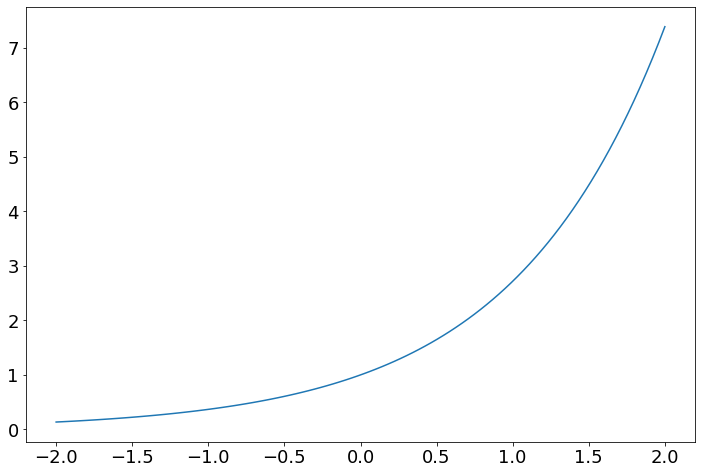

In [244]:
eixo_x = np.linspace(-2,2,100) # definindo um eixo x com 100 valores de -2 a 2.
y_exp = np.exp(eixo_x) # o eixo_y é o cálculo da esponencial de todos valores na array do eixo_x
sns.lineplot(x=eixo_x, y=y_exp)

plt.show()

Podemos usar uma escala em função logaritmica para analisar mais a fundo o gráfico exponencial acima. 

Exemplos de funções log:
$$ log_2 2 = 1$$
$$ log_2 2^x = x $$
$$ log_e e^x = x $$

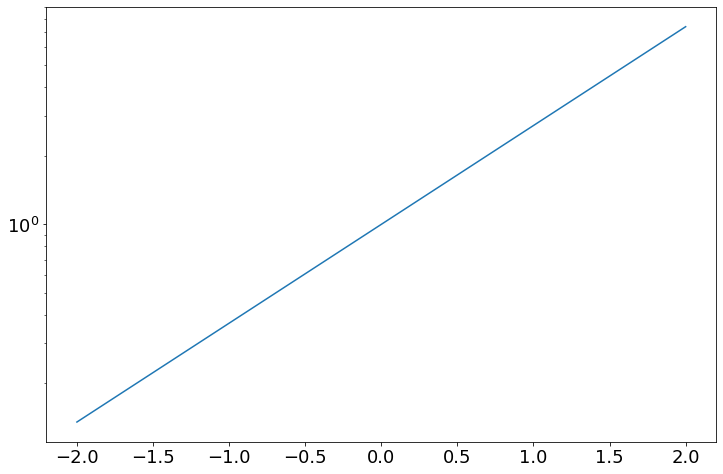

In [245]:
# Mudando o gráfico acima para escala log
sns.lineplot(x=eixo_x, y=y_exp)
mpl.pyplot.yscale('log') # definindo a escala do gráfico para uma escala 'log'

Repare acima que, ao aplicarmos o log, os dados deixaram de ter um crescimento exponencial e passaram a ter um crescimento linear. Isso quer dizer que, se aplicarmos o log aos dados da pandemia e o crescimento for exponencial, nosso resultado devera ser uma reta também.

Portanto, vamos replicar o que foi feito acima nos dados da pandemia, mas apenas do município de São Paulo, de modo a simplificar esta análise. 

In [246]:
dados_sp = dados.query('nome_munic == "São Paulo"') # pegado apenas as informações do municipio de SP
dados_sp

,nome_munic,codigo_ibge,dia,mes,datahora,casos,casos_novos,casos_pc,casos_mm7d,obitos,obitos_novos,obitos_pc,obitos_mm7d,letalidade,nome_ra,cod_ra,nome_drs,cod_drs,pop,pop_60,area,map_leg,map_leg_s,latitude,longitude,semana_epidem
562,São Paulo,3550308,25,2,2020-02-25,1,0,"8,424841e-03","0,0000000",0,0,"0,000000e+00","0,0000000","0,0000000000",RM de São Paulo,10,Grande São Paulo,10,11869660,1853286,152111,<50,7.0,"-23,5329","-46,6395",9
1207,São Paulo,3550308,26,2,2020-02-26,1,0,"8,424841e-03","0,0000000",0,0,"0,000000e+00","0,0000000","0,0000000000",RM de São Paulo,10,Grande São Paulo,10,11869660,1853286,152111,<50,7.0,"-23,5329","-46,6395",9
1852,São Paulo,3550308,27,2,2020-02-27,1,0,"8,424841e-03","0,0000000",0,0,"0,000000e+00","0,0000000","0,0000000000",RM de São Paulo,10,Grande São Paulo,10,11869660,1853286,152111,<50,7.0,"-23,5329","-46,6395",9
2497,São Paulo,3550308,28,2,2020-02-28,2,1,"1,684968e-02","0,0000000",0,0,"0,000000e+00","0,0000000","0,0000000000",RM de São Paulo,10,Grande São Paulo,10,11869660,1853286,152111,<50,7.0,"-23,5329","-46,6395",9
3142,São Paulo,3550308,29,2,2020-02-29,2,0,"1,684968e-02","0,0000000",0,0,"0,000000e+00","0,0000000","0,0000000000",RM de São Paulo,10,Grande São Paulo,10,11869660,1853286,152111,<50,7.0,"-23,5329","-46,6395",9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283072,São Paulo,3550308,8,5,2021-05-08,735057,1998,"6,192738e+03","1956,5714286",28309,178,"2,384988e+02","114,5714286","0,0385126596",RM de São Paulo,10,Grande São Paulo,10,11869660,1853286,152111,>5000,1.0,"-23,5329","-46,6395",18
283717,São Paulo,3550308,9,5,2021-05-09,736342,1285,"6,203564e+03","2024,1428571",28347,38,"2,388190e+02","116,7142857","0,0384970571",RM de São Paulo,10,Grande São Paulo,10,11869660,1853286,152111,>5000,1.0,"-23,5329","-46,6395",19
284362,São Paulo,3550308,10,5,2021-05-10,736880,538,"6,208097e+03","2008,1428571",28364,17,"2,389622e+02","114,1428571","0,0384920204",RM de São Paulo,10,Grande São Paulo,10,11869660,1853286,152111,>5000,1.0,"-23,5329","-46,6395",19
285007,São Paulo,3550308,11,5,2021-05-11,739821,2941,"6,232874e+03","2039,1428571",28583,219,"2,408072e+02","120,0000000","0,0386350212",RM de São Paulo,10,Grande São Paulo,10,11869660,1853286,152111,>5000,1.0,"-23,5329","-46,6395",19


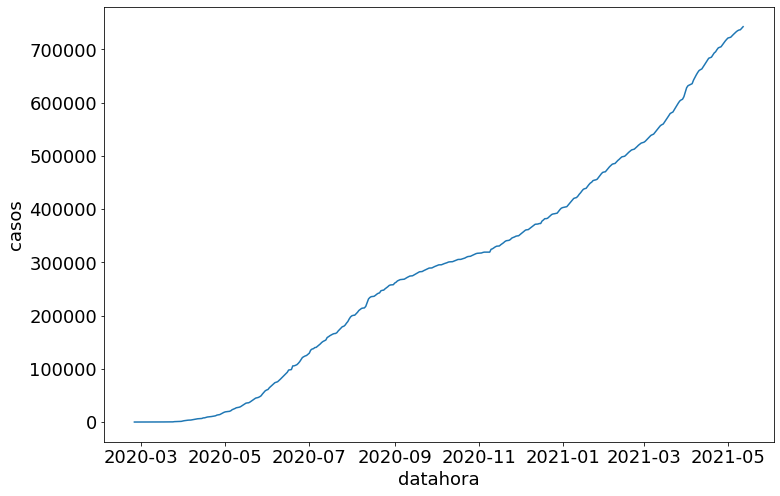

In [247]:
# Line plot dos dados de SP
sns.lineplot(x='datahora', y='casos', data=dados_sp)

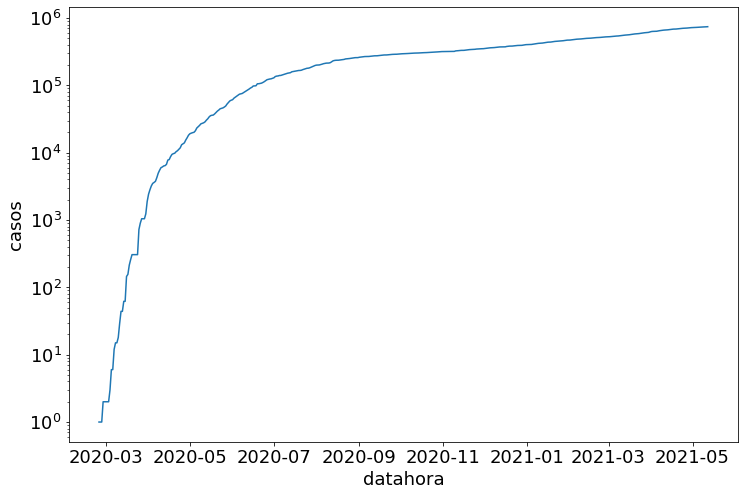

In [248]:
# Plot com o eixo y em função log => gráfico monolog (1 eixo em função log)
sns.lineplot(x='datahora', y='casos', data=dados_sp)
mpl.pyplot.yscale('log')

Do contrário de nossa hipótese anterior, de que o gráfico resultante seria uma reta, este resultou em uma parábola.
A função logaritmica pode ser utilizada para uniformizar os resultados, deixando de fora a deformização do gráfico por outliers.

No gráfico acima, podemos observar uma taxa de crescimento maior do numero de casos em função do mês/ano. A partir de agosto, a curva começa a representar constância do crescimento casos de COVID-19

**Taxa de crescimento e média móvel**

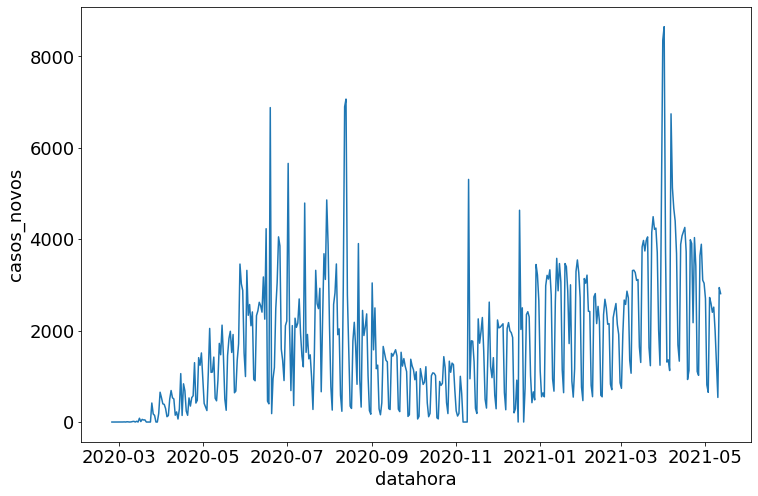

In [249]:
# plot dos casos de COVID em SP
sns.lineplot(x='datahora', y='casos_novos', data=dados_sp)

Vamos calcular a diferenciação dos dados do df de SP para suavizarmos os resultados de modo a verificar se há uma tendência nos resultados.

In [250]:
# Exemplo de uma reta diferenciada
dados_ex = pd.DataFrame(data=np.linspace(1,10,10)) # linspace de 1 a 10, 10 pontos (espaçamento)
dados_ex.head()

,0
0,1.0
1,2.0
2,3.0
3,4.0
4,5.0


In [251]:
dados_ex['diferenciado'] = dados_ex.diff() # função que pega um valor e subtrai o anterior sucessivamente

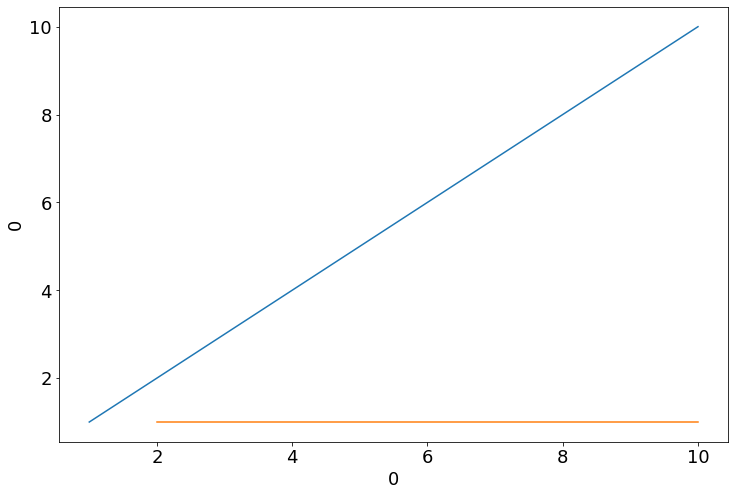

In [252]:
# Gráfico exemplificando a diferenciação de uma reta
sns.lineplot(data=dados_ex, x=0, y=0)
sns.lineplot(data=dados_ex, x=0, y='diferenciado') # linha da diferenciação (laranja) 

A diferenciação (linha laranja) do gráfico acima (linha azul) é uma reta horizontal pois, neste caso, o tamanho da diferença entre o valor consecutivo e o anterior é sempre a mesma, o crescimento é sempre igual. Já no crescimento exponencial, onde o crescimento é dado por uma razão ao invés de uma diferenciação, espera-se que o resultado não seja uma reta.

No gráfico acima, o coeficiente angular (a) da tera é igual a 1: y = ax + b = 1x + b 

**Construção do gráfico dos dados diferenciados de casos e óbitos**

In [253]:
# Diferenciação dos dados de casos e óbitos
dados_sp['taxa_crescimento_casos'] = dados_sp['casos_novos'].diff()
dados_sp['taxa_crescimento_obitos'] = dados_sp['obitos_novos'].diff()

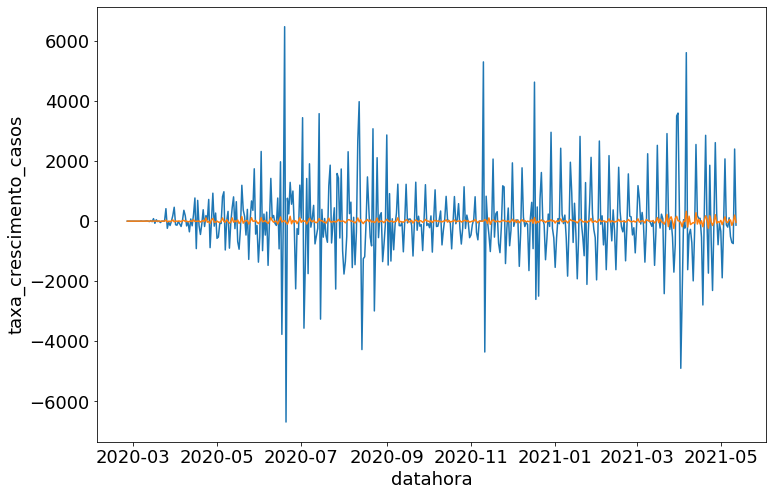

In [254]:
# Line plot da diferença dos casos e óbitos de sp em função do tempo
sns.lineplot(x='datahora', y='taxa_crescimento_casos', data=dados_sp)
sns.lineplot(x='datahora', y='taxa_crescimento_obitos', data=dados_sp)

No gráfico acima, pdemos perceber que, onde há picos no número de casos (linha azul), também há picos no número de óbitos (linha laranja). Ou seja, o número de casos informados pode estar relacionado ao número de óbitos.

<BarContainer object of 443 artists>

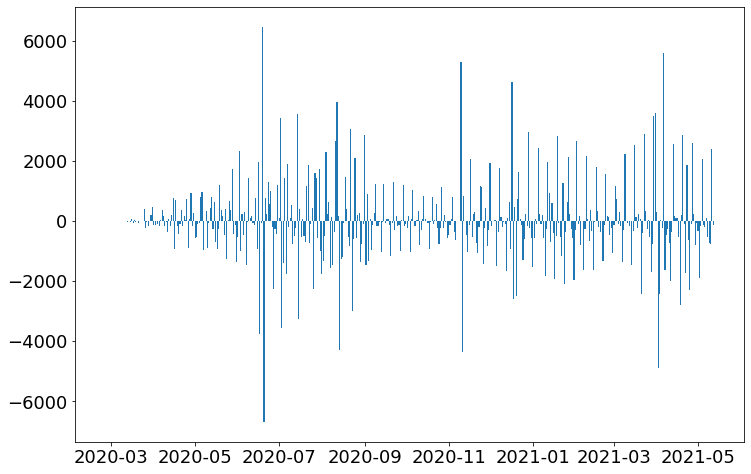

In [255]:
# Bar plot da taxa de crescimento dos casos em sp em função do tempo
plt.bar(dados_sp['datahora'], dados_sp['taxa_crescimento_casos'])

Para vizualizar melhor os dados acima, vamos averiguar apenas os dados de 2020

In [256]:
# Criando uma coluna 'ano' com apenas o ano das informações da coluna datahora
# no df dos dados de COVID no municipio de São Paulo
dados_sp['ano'] = pd.DatetimeIndex(dados_sp['datahora']).year
dados_sp['ano'].head()

562     2020
1207    2020
1852    2020
2497    2020
3142    2020
Name: ano, dtype: int64

In [257]:
# Formando um df com os dados de COVID apenas de 2021 no municipio de São Paulo 
dados_sp_2021 = dados_sp.query('ano==2021')
dados_sp_2021.head()

,nome_munic,codigo_ibge,dia,mes,datahora,casos,casos_novos,casos_pc,casos_mm7d,obitos,obitos_novos,obitos_pc,obitos_mm7d,letalidade,nome_ra,cod_ra,nome_drs,cod_drs,pop,pop_60,area,map_leg,map_leg_s,latitude,longitude,semana_epidem,taxa_crescimento_casos,taxa_crescimento_obitos,ano
201157,São Paulo,3550308,1,1,2021-01-01,402835,1117,"3,393821e+03","1714,4285714",15695,16,"1,322279e+02","35,1428571","0,0389613614",RM de São Paulo,10,Grande São Paulo,10,11869660,1853286,152111,>5000,1.0,"-23,5329","-46,6395",53,-1540.0,-62.0,2021
201802,São Paulo,3550308,2,1,2021-01-02,403388,553,"3,398480e+03","1733,0000000",15716,21,"1,324048e+02","37,1428571","0,0389600087",RM de São Paulo,10,Grande São Paulo,10,11869660,1853286,152111,>5000,1.0,"-23,5329","-46,6395",53,-564.0,5.0,2021
202447,São Paulo,3550308,3,1,2021-01-03,404025,637,"3,403846e+03","1729,7142857",15725,9,"1,324806e+02","37,4285714","0,0389208589",RM de São Paulo,10,Grande São Paulo,10,11869660,1853286,152111,>5000,1.0,"-23,5329","-46,6395",1,84.0,-12.0,2021
203092,São Paulo,3550308,4,1,2021-01-04,404576,551,"3,408489e+03","1739,2857143",15743,18,"1,326323e+02","38,0000000","0,0389123428",RM de São Paulo,10,Grande São Paulo,10,11869660,1853286,152111,>5000,1.0,"-23,5329","-46,6395",1,-86.0,9.0,2021
203737,São Paulo,3550308,5,1,2021-01-05,407557,2981,"3,433603e+03","1673,0000000",15836,93,"1,334158e+02","42,1428571","0,0388559146",RM de São Paulo,10,Grande São Paulo,10,11869660,1853286,152111,>5000,1.0,"-23,5329","-46,6395",1,2430.0,75.0,2021


**Gráfico da taxa de crescimento do número de casos de COVID em 2021, SP**

Barplot Gráfico do crecimento e diminuição dos casos de COVID de 2021 no municipio de São Paulo  

(array([737791., 737812., 737822., 737843., 737850., 737871., 737881.,
        737902., 737911.]), <a list of 9 Text major ticklabel objects>)

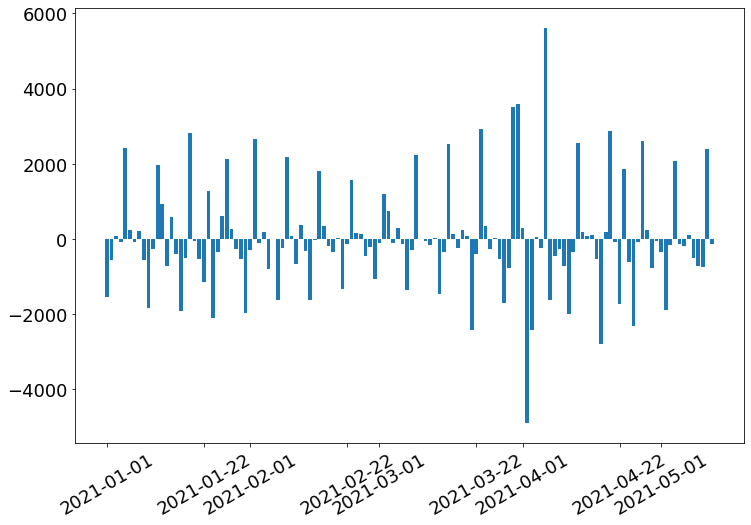

In [258]:
plt.bar(dados_sp_2021['datahora'],dados_sp_2021['taxa_crescimento_casos'])
plt.xticks(rotation=30)

**Verificando a tendencia dos casos e óbitos por COVID em uma janela de 7 dias de 2020 no município de São Paulo**

Média movel do número de casos e óbitos do COVID em são paulo de uma janela de menos 7 dias:

In [259]:
# rolling(window=7, center=False) -> janela de dados que queremos vizualizar. Siginifica
# que queremos uma 'janela' de tamamnho '7' que é localizada no 'inicio', e não no 'centro' 
# da coluna de dados
dados_sp['media_movel_casos'] = dados_sp['casos_novos'].rolling(window=7, center=False).mean()
dados_sp['media_movel_obitos'] = dados_sp['obitos_novos'].rolling(window=7, center=False).mean()

Line plots do número de casos (linha azul) e da média móvel dos casos (linha laranja) por COVID em função do tempo:

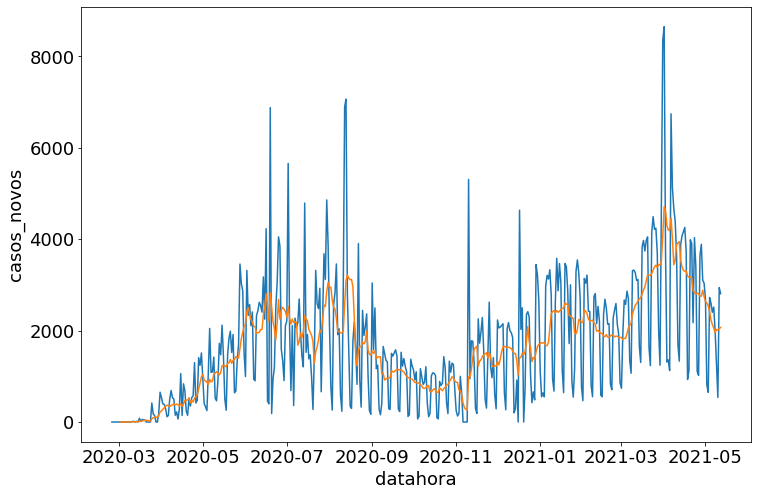

In [260]:
sns.lineplot(x='datahora', y='casos_novos', data=dados_sp)
sns.lineplot(x='datahora', y='media_movel_casos', data=dados_sp)

**Correlação e função de autocorrelação**

Verificando o tipo de correlação entre o número de casos novos na série temporal com o número de casos novos na série temporal:

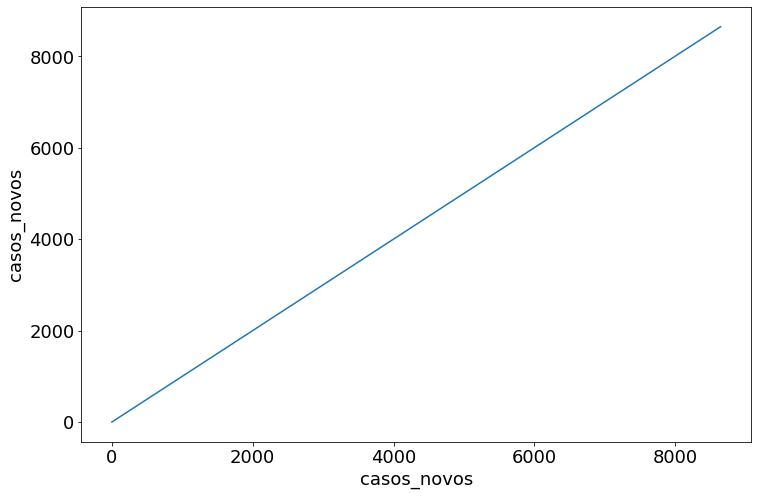

In [261]:
sns.lineplot(x='casos_novos', y='casos_novos', data=dados_sp)

O resultado é uma correlação linear perfeita e positiva, que sugere uma ótima correlação entre os dados.

Vereificando o tipo de relação entre o número de óbitos e o número de casos novos para COVID em SP:

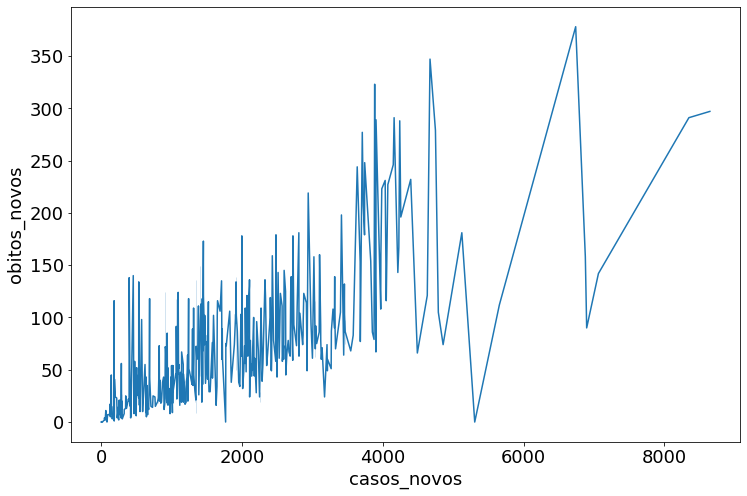

In [262]:
sns.lineplot(x='casos_novos', y='obitos_novos', data=dados_sp)

Como podemos ver acima, também há aqui uma correlação crescente. No entanto, esta correlação náo está perfeitamente linear.

Vamos agora verificar os número de casos reportados nos dias dos primeiros 2 meses do ano de 2021 no municipio de São Paulo para verificar se há alguma sasonalidade:

In [263]:
dados_jan2021 = dados_sp.query('mes==1 & ano==2021')
dados_fev2021 = dados_sp.query('mes==2 & ano==2021')

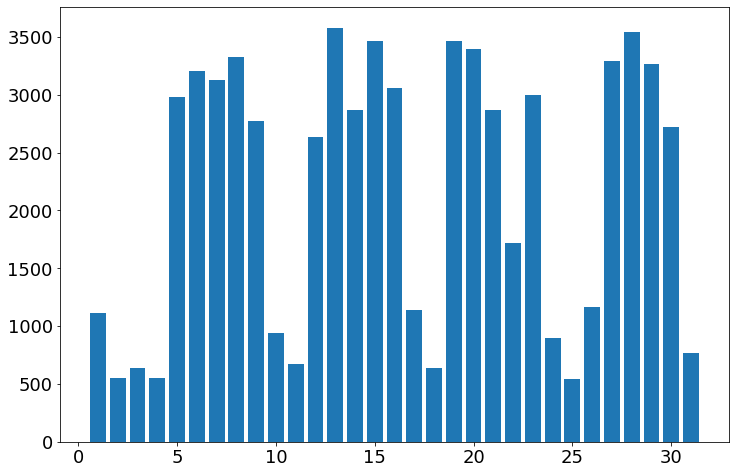

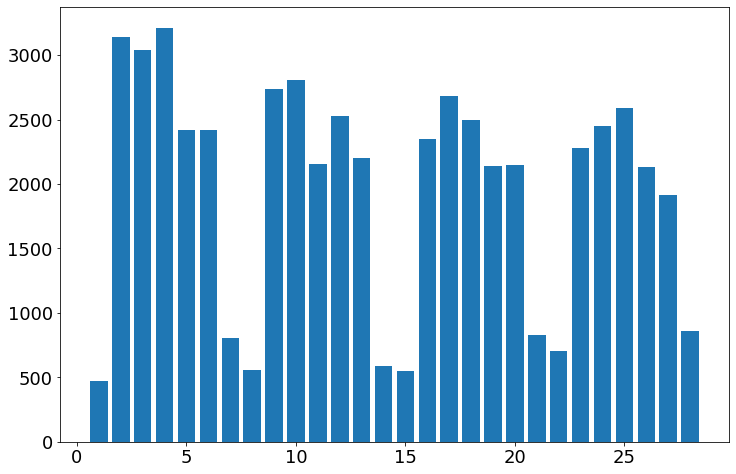

In [264]:
plt.bar(np.linspace(1,31,31),dados_jan2021['casos_novos'])
plt.show()
plt.bar(np.linspace(1,28,28),dados_fev2021['casos_novos'])
plt.show()

A partir dos gráficos acima podemos perceber uma sazonalidade, na qual o dia do mês interfere no número de casos reportados. Os dias da semana, nos quais há uma baixa no número de casos, coincidem com os domingos, segundas e feriados do calendário de janeiro e fevereiro 2021. Deste modo, podemos dizer que há uma notificação menor dos casos de COVID aos domingos, segundas e feriados.

**Gráficos de autocorrelação**

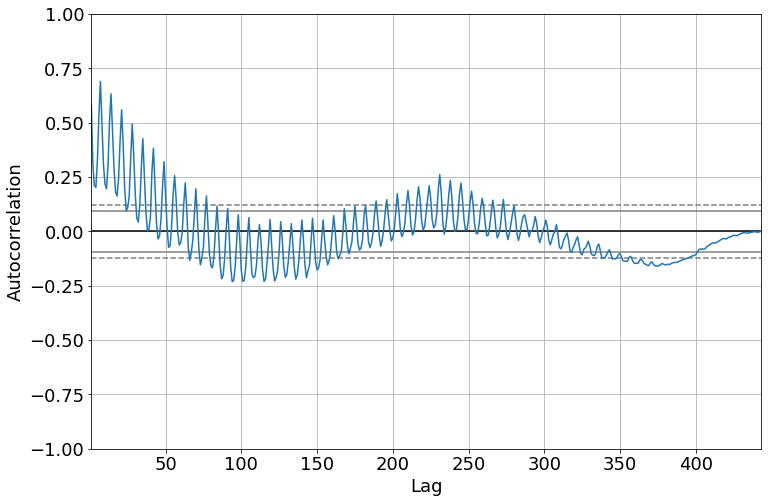

In [265]:
autocorrelation_plot(dados_sp['casos_novos'])

Os picos no gráfico acima, na série temporal do COVID, podemos perceber alguns pícos muito altos de autocorrelação, que nos mostram que há uma dependência temporal entre esses dados, são comparáveis em relação ao tempo, nos indicando uma sasonalidade. Do mesmo modo, ao final da linha, onde os resultados estão muito próximos de zero, os dados não são mais comparáveis temporalmente como os do início. Ou seja, o momento atual da pandemia (2021) não é mais comparável ao tempo, como ocorria no início do ano passado (2020).

In [266]:
dados_sp.shape

(443, 31)

In [267]:
aleatorio = np.random.rand(443) #443 valores aleatórios dentro do vetor aleatório

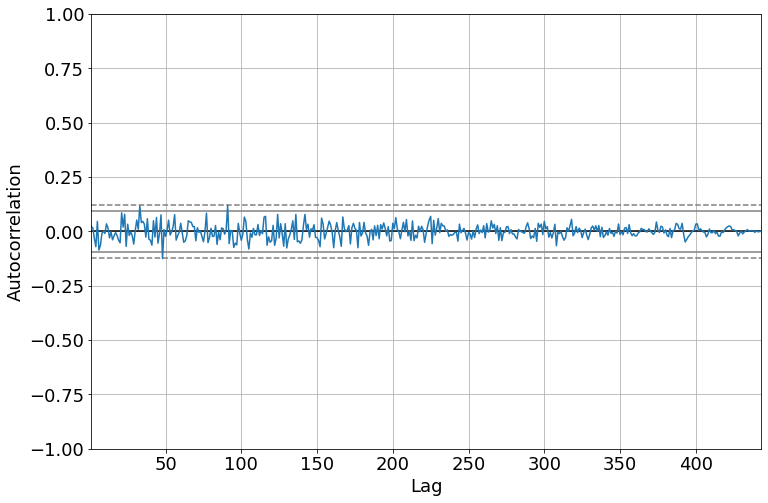

In [268]:
autocorrelation_plot(aleatorio)

No gráfico acima, da série aleatória, não é possível verificar uma autocorrelação expressíva, ela é espuria, ou seja, não há dependência temporal nesses valores, eles são aleatórios, muito próximos de zero, não representam sasonalidade em nossa base de dados.

### **01. Desafios**

**Desafio 01: Um notebook sem warnings**

[Solucionado](https://stackoverflow.com/questions/9031783/hide-all-warnings-in-ipython) com a adição da biblioteca 'warnings', no início do notebook, e o comando 'warnings.filterwarnings('ignore')'.

In [269]:
# # removing warnings
# import warnings
# warnings.filterwarnings('ignore')

**Desafio 02: Pico taxa de casos novos coincide com taxa dos óbitos novos.**

**Desafio 03: Fazer melhorias nos gráficos.**

**Desafio 04: Gerar o gráfico da média móvel do número de óbitos e mudar os gráficos de casos para barras.**

Line plots do número de óbitos novos (linha azul) e da média móvel dos óbitos (linha laranja) por COVID em função do tempo:

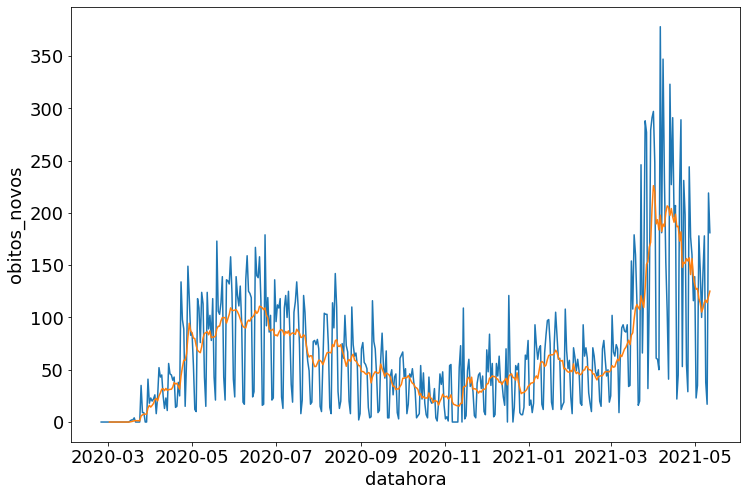

In [270]:
sns.lineplot(x='datahora', y='obitos_novos', data=dados_sp)
sns.lineplot(x='datahora', y='media_movel_obitos', data=dados_sp)

(array([737485., 737546., 737607., 737669., 737730., 737791., 737850.,
        737911.]), <a list of 8 Text major ticklabel objects>)

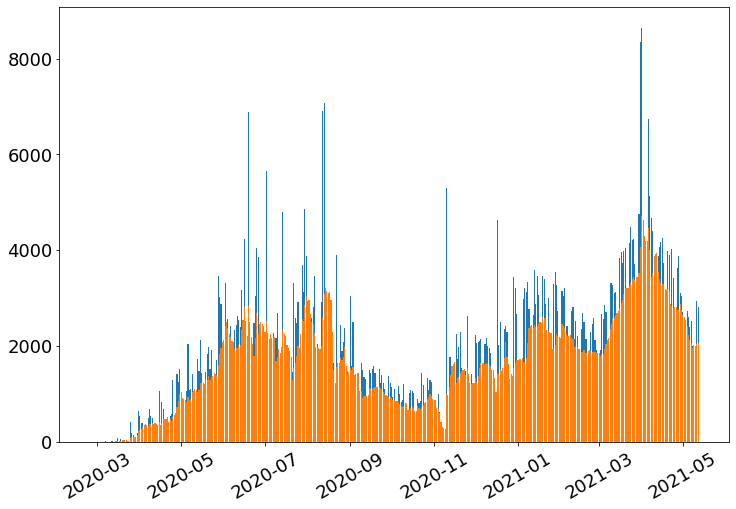

In [271]:
plt.bar(dados_sp['datahora'], dados_sp['casos_novos'])
plt.bar(dados_sp['datahora'], dados_sp['media_movel_casos'])
plt.xticks(rotation=30)

**Desafio 05: Mover o número de óbitos alguns dias para verificar o resultado no gráfico.**

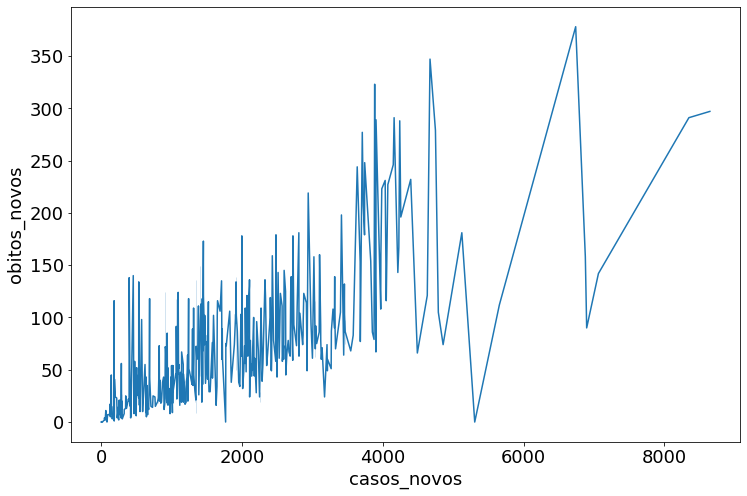

In [272]:
sns.lineplot(x='casos_novos', y='obitos_novos', data=dados_sp)

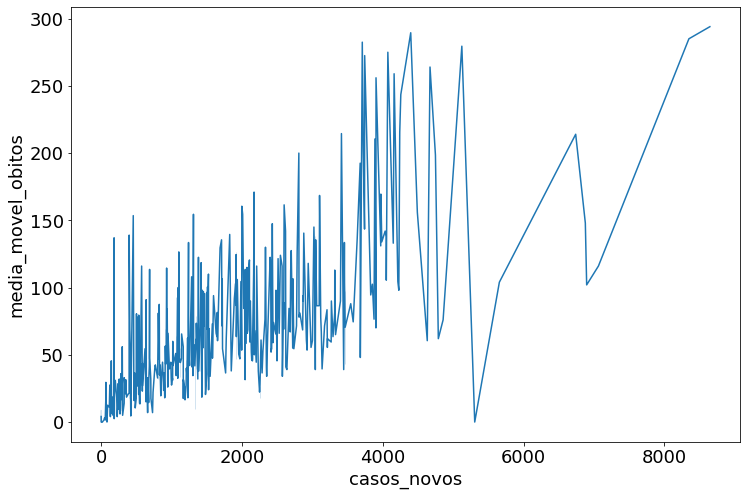

In [273]:
dados_sp['media_movel_obitos'] = dados_sp['obitos_novos'].rolling(window=2, center=False).mean()
sns.lineplot(x='casos_novos', y='media_movel_obitos', data=dados_sp)

**Desafio 06: Função de correlação cruzada dos óbitos e casos.**

https://www.ti-enxame.com/pt/python/correlacao-cruzada-correlacao-time-lag-com-pandas/1056889561/

**Desafio 07: Estudar outros municípios utilizando outra função para filtrar a base de dados.**

ref. 2: https://www.delftstack.com/pt/howto/python-pandas/how-to-filter-dataframe-rows-based-on-column-values-in-pandas/

In [274]:
dados_pc = dados[dados['nome_munic'] == 'Piracicaba']
dados_pc.head()

,nome_munic,codigo_ibge,dia,mes,datahora,casos,casos_novos,casos_pc,casos_mm7d,obitos,obitos_novos,obitos_pc,obitos_mm7d,letalidade,nome_ra,cod_ra,nome_drs,cod_drs,pop,pop_60,area,map_leg,map_leg_s,latitude,longitude,semana_epidem
433,Piracicaba,3538709,25,2,2020-02-25,0,0,"0,000000e+00","0,0000000",0,0,"0,000000e+00","0,0000000","0,0000000000",RA de Campinas,4,Piracicaba,11,389873,64835,137807,0,8.0,"-22,7338","-47,6476",9
1078,Piracicaba,3538709,26,2,2020-02-26,0,0,"0,000000e+00","0,0000000",0,0,"0,000000e+00","0,0000000","0,0000000000",RA de Campinas,4,Piracicaba,11,389873,64835,137807,0,8.0,"-22,7338","-47,6476",9
1723,Piracicaba,3538709,27,2,2020-02-27,0,0,"0,000000e+00","0,0000000",0,0,"0,000000e+00","0,0000000","0,0000000000",RA de Campinas,4,Piracicaba,11,389873,64835,137807,0,8.0,"-22,7338","-47,6476",9
2368,Piracicaba,3538709,28,2,2020-02-28,0,0,"0,000000e+00","0,0000000",0,0,"0,000000e+00","0,0000000","0,0000000000",RA de Campinas,4,Piracicaba,11,389873,64835,137807,0,8.0,"-22,7338","-47,6476",9
3013,Piracicaba,3538709,29,2,2020-02-29,0,0,"0,000000e+00","0,0000000",0,0,"0,000000e+00","0,0000000","0,0000000000",RA de Campinas,4,Piracicaba,11,389873,64835,137807,0,8.0,"-22,7338","-47,6476",9


## **02. First predictions**

**First predictions with Prophet**

In [275]:
# Criando um dataframe (df) genérico
df = pd.DataFrame()

In [276]:
# Criando as colunas 'ds' e 'y' em nosso df a partir das colunas 'datahora' e 'casos_novos'
df['ds'] = dados_sp['datahora']
df['y'] = dados_sp['casos_novos']
df.head()

,ds,y
562,2020-02-25,0
1207,2020-02-26,0
1852,2020-02-27,0
2497,2020-02-28,1
3142,2020-02-29,0


O prophet é um algaritmo de machine learning. Para aplicarmos um algaritmo de machine learning precisamos de um modelo:

In [277]:
# Modelo
modelo = Prophet()

In [278]:
# Determinando do fitting (ajuste), a reta, dos nosso df
modelo.fit(df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Em qualquer modelo de previsão, não só o de uma série temporal, mas qualquer outro, buscamos o melhor coeficiente para ajustar o modelo aos nossos dados conhecidos. Isto é, o modelo fará a previsão segundo os dados que fornecemos, assumindo a existência de uma tendência, respeitando a organização dos dados conhecidos.

Para visualizarmos nossa primeira previsão, precisamos indicar o número de dias que queremos prever, então, temos que criar um dataframe com essas datas:

In [279]:
dataframefuturo = modelo.make_future_dataframe(periods=20)
# em 'periods' indicamos o número interno de períodos a serem previstos.
# https://rdrr.io/cran/prophet/man/make_future_dataframe.html

dataframefuturo.head()

,ds
0,2020-02-25
1,2020-02-26
2,2020-02-27
3,2020-02-28
4,2020-02-29


In [280]:
# Prevendo os valores para as datas selecionadas acima
previsao = modelo.predict(dataframefuturo)

previsao.head()
# Obs.: o 'yhat' é um simbulo de previsão/estimativa

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-02-25,-114.303728,-807.606500,1551.996213,-114.303728,-114.303728,500.316952,500.316952,500.316952,500.316952,500.316952,500.316952,0.0,0.0,0.0,386.013224
1,2020-02-26,-96.932780,-780.494704,1580.155972,-96.932780,-96.932780,554.767711,554.767711,554.767711,554.767711,554.767711,554.767711,0.0,0.0,0.0,457.834930
2,2020-02-27,-79.561833,-618.167828,1775.865046,-79.561833,-79.561833,650.710000,650.710000,650.710000,650.710000,650.710000,650.710000,0.0,0.0,0.0,571.148167
3,2020-02-28,-62.190885,-835.615294,1459.004460,-62.190885,-62.190885,368.442066,368.442066,368.442066,368.442066,368.442066,368.442066,0.0,0.0,0.0,306.251181
4,2020-02-29,-44.819937,-1232.354009,1149.358585,-44.819937,-44.819937,30.824737,30.824737,30.824737,30.824737,30.824737,30.824737,0.0,0.0,0.0,-13.995200


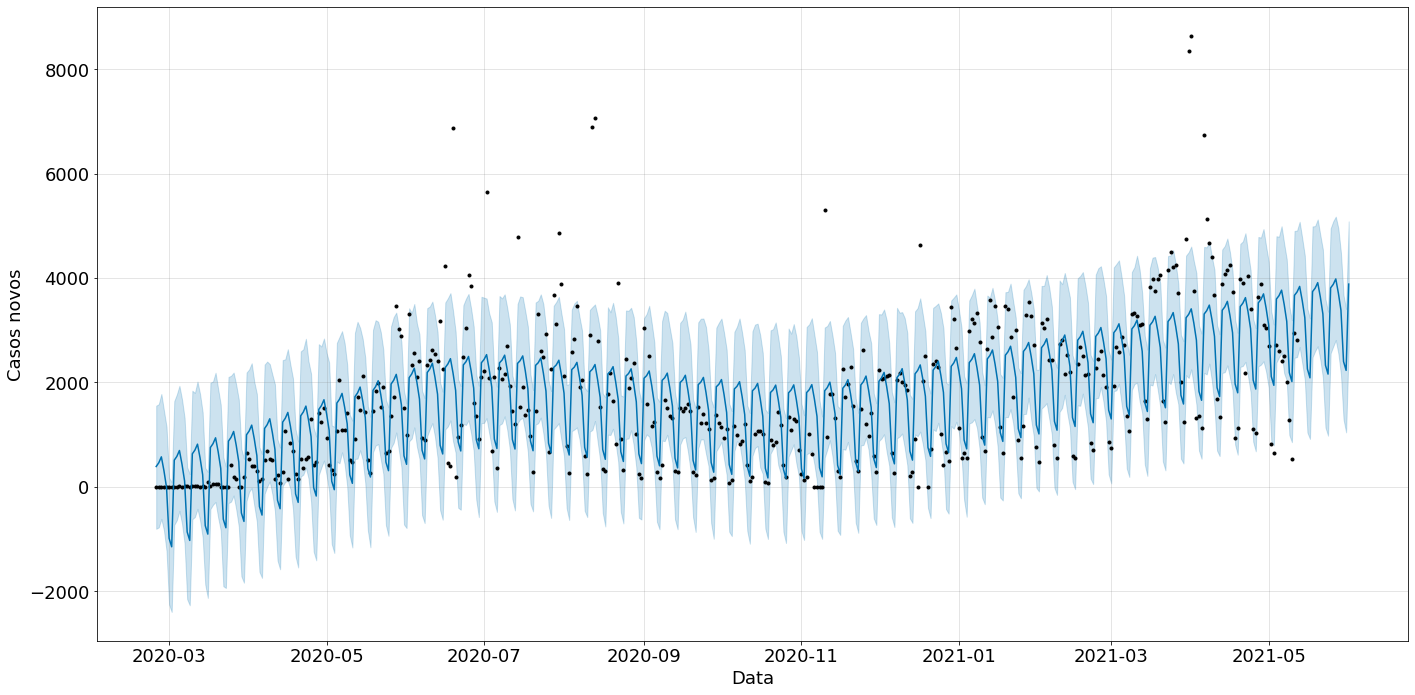

In [281]:
# Gráfico da previsão acima
modelo.plot(previsao, xlabel='Data', ylabel='Casos novos', figsize=(20,10));

Obs.: colocamos o ';' ao final do código que plota o gráfico para evitar que ele projete dois do mesmo gráfico.

Os pontinhos pretos no nosso gráfico são os dados reais, do número de casos de COVID, do nosso dataframe 'dados_sp'. No gráfico acima, buscamos ajustar nosso modelo à esses dados. O modelo sugerido é a linha azul escura. Esse modelo sugere, nos picos e quedas formados, o mesmo padrão observado nos gráficos dos meses de janeiro e fevereiro, 2020, do capítulo anterior, sobre sazonalidade.

Ao rodarmos o profit, anteriormente (modelo.fit(df)), fomos infromados que o profit:
1. Desabiltou uma sasonalidade anual do dados: Run prophet with yearly_seasonality=True to override this.
2.  Desabiltou uma sasonalidade diária do dados: Run prophet with daily_seasonality=True to override this.

Além disso, sabemos que o profit também tem uma sazonabilidade semanal, a qual não foi desabilitada. 

Vamos, em seguida, verificar se ele identificou, por conta própria, que há uma sazonalidade semanal em nosso padrão e averiguar a confiabilidade do resultado de nosso modelo.

In [282]:
# Criando um df a partir dos primeiros 400 pontos das colunas 'datahora' e 'casos_novos'

df = pd.DataFrame()

df['ds'] = dados_sp['datahora'][:400]
df['y'] = dados_sp['casos_novos'][:400]

modelo = Prophet()
modelo.fit(df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [283]:
dataframefuturo = modelo.make_future_dataframe(periods=43)
previsao = modelo.predict(dataframefuturo)
previsao.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-02-25,-137.621348,-733.569035,1378.530128,-137.621348,-137.621348,457.699352,457.699352,457.699352,457.699352,457.699352,457.699352,0.0,0.0,0.0,320.078004
1,2020-02-26,-119.843618,-694.319804,1408.853029,-119.843618,-119.843618,456.859942,456.859942,456.859942,456.859942,456.859942,456.859942,0.0,0.0,0.0,337.016324
2,2020-02-27,-102.065887,-634.311142,1534.743447,-102.065887,-102.065887,596.079908,596.079908,596.079908,596.079908,596.079908,596.079908,0.0,0.0,0.0,494.014021
3,2020-02-28,-84.288157,-806.232115,1344.392805,-84.288157,-84.288157,340.781628,340.781628,340.781628,340.781628,340.781628,340.781628,0.0,0.0,0.0,256.493471
4,2020-02-29,-66.510426,-1087.475147,1084.644652,-66.510426,-66.510426,59.114795,59.114795,59.114795,59.114795,59.114795,59.114795,0.0,0.0,0.0,-7.395631


In [284]:
# Criando um df a partir dos pontos finais, após os 400, das 'colunas' datahora e 'casos_novos'

df_teste = pd.DataFrame()
df_teste['ds'] =dados_sp['datahora'][400:]
df_teste['y'] =dados_sp['casos_novos'][400:]

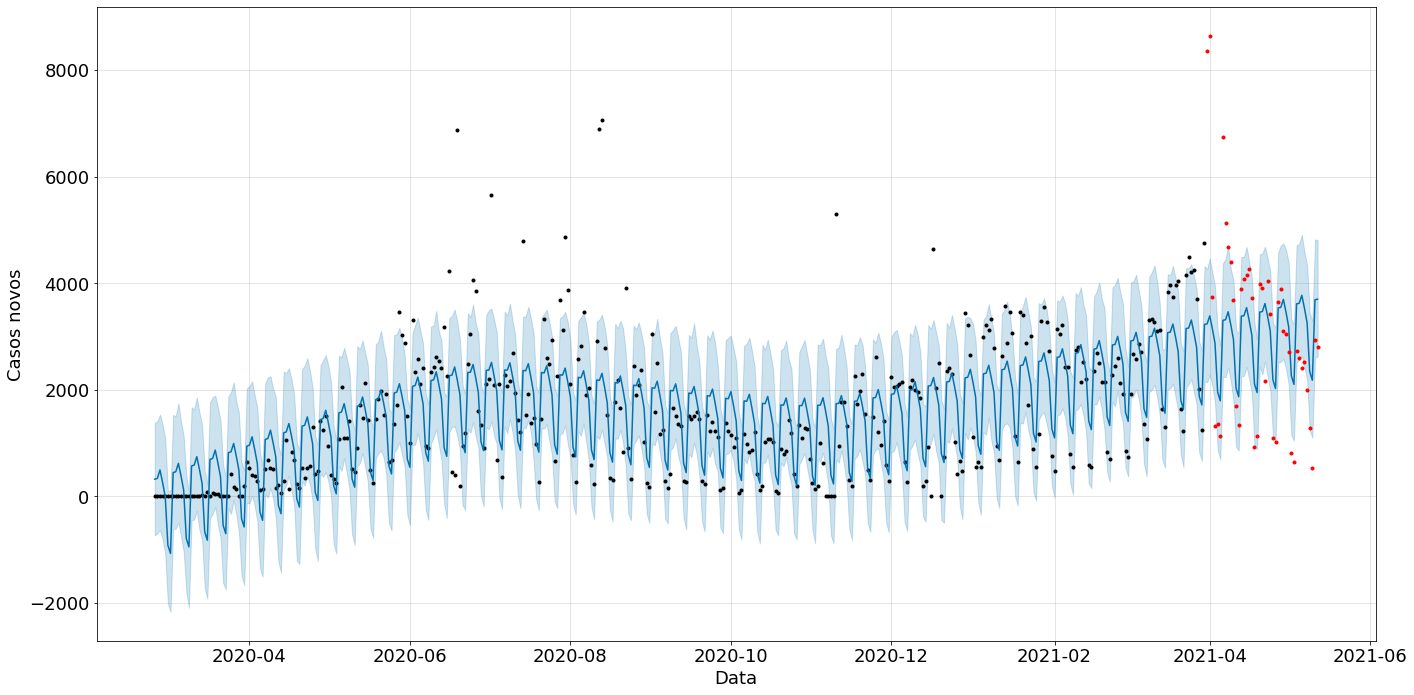

In [285]:
modelo.plot(previsao, xlabel='Data', ylabel='Casos novos', figsize=(20,10));
plt.plot(df_teste['ds'], df_teste['y'], '.r') # '.r' foi utilizado para diferenciar o plot 2 do 1

Acima plotamos um modelo de previsão (nas cor azul) dos 400 pontos iniciais dos 'casos_novos' de COVID em função da data (pontos pretos) e os pontos finais (pontos de teste), após os 400, da mesma coluna (pontos vermelhos). Através disso, percebemos que nossa previsão ão é muito confiável, pois os pontos vermelhos, que não foram incluídos para definir nosso modelo, estão, em sua maioria, fora da linha azul. Deste modo iremos tentar ajustar melhor nossa curva do modelo de previsão

Plot da tendencia geral (de abril de 2020 a junho de 2021) e da sasonalidade semanal dos dados plotados acima:

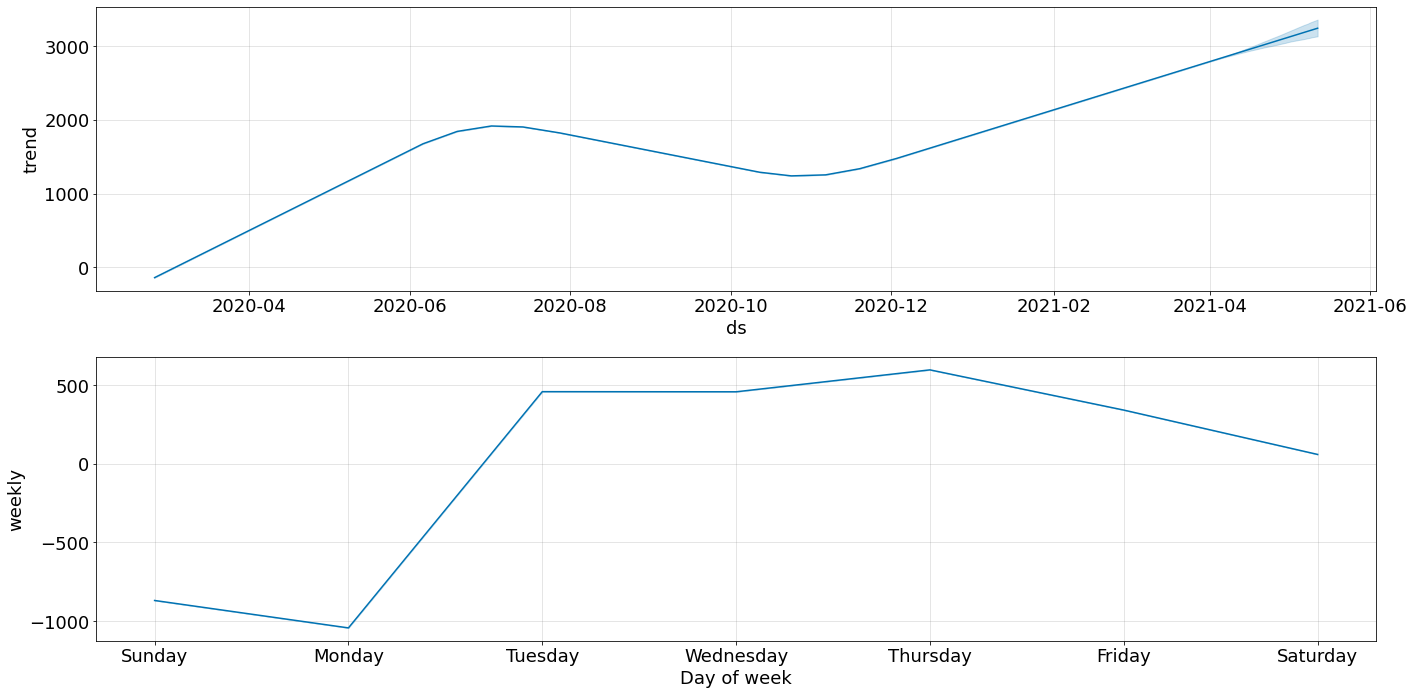

In [286]:
modelo.plot_components(previsao, figsize=(20,10));

O sefundo gráfico abaixo nos mostra que as segundas e aos domingos, há uma quantidade menor de casos sendo mostrado em nosso dataframe.

### **02. Desafios**

**Desafio 08: Mudar os períodos de previsão.**

In [312]:
# Criando um df a partir dos pontos entre o 200° (ducentésimo) e o 500° (quingentésimo) 
# das colunas 'datahora' e 'casos_novos'
df = pd.DataFrame()
df['ds'] = dados_sp['datahora'][200:500]
df['y'] = dados_sp['casos_novo'][200:500]
df.head()

KeyError: ignored

In [313]:
# Criando um df a partir do 500° (quingentésimo) das colunas 'datahora' e 'casos_novos'.
df_teste = pd.DataFrame()
df_teste['ds'] =dados_sp['datahora'][500:]
df_teste['y'] =dados_sp['casos_novos'][500:]
df.head()

,ds
129562,2020-09-12
130207,2020-09-13
130852,2020-09-14
131497,2020-09-15
132142,2020-09-16


In [310]:
# Determinando do fitting (ajuste), a reta, do nosso df
modelo = Prophet()
modelo.fit(df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


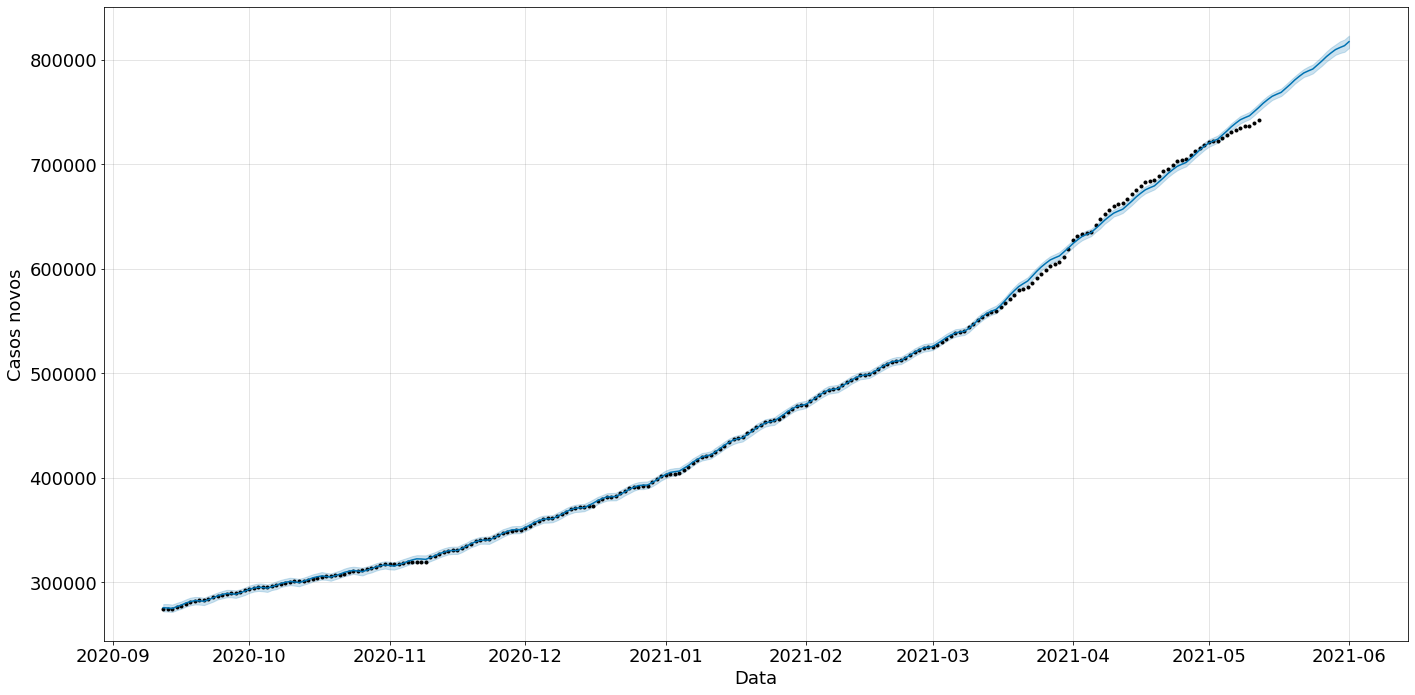

In [311]:
# em 'periods' indicamos o número interno de períodos a serem previstos.
dataframefuturo = modelo.make_future_dataframe(periods=20)
dataframefuturo.head()

# Prevendo os valores para o periodo selecionado
previsao = modelo.predict(dataframefuturo)
previsao.head()

# Gráfico da previsão acima
modelo.plot(previsao, xlabel='Data', ylabel='Casos novos', figsize=(20,10));
plt.plot(df_teste['ds'], df_teste['y'], '.r')

**Desafio 09: Explorar a documentação do Prophet e melhorar os gráficos.**

Profet, Procedimento de Previsão Automática: implementa um procedimento para previsão de dados de série temporal com base em um modelo aditivo onde tendências não lineares são ajustadas com sazonalidade anual, semanal e diária, além dos efeitos de feriados. Funciona melhor com séries temporais que têm fortes efeitos sazonais e várias temporadas de dados históricos. O Prophet é robusto para dados ausentes e mudanças na tendência, e normalmente lida bem com outliers.

Funções do Prophet:
https://rdrr.io/cran/prophet/man/

**Desafio 10: Fazer todo o processo de previsão para o número de casos acumulados.**

In [305]:
# Criando um df a partir das colunas 'datahora' e 'casos_novos'
df = pd.DataFrame()
df['ds'] = dados_sp['datahora']
df['y'] = dados_sp['casos']
df.head()

,ds,y
562,2020-02-25,1
1207,2020-02-26,1
1852,2020-02-27,1
2497,2020-02-28,2
3142,2020-02-29,2


In [306]:
# Determinando do fitting (ajuste), a reta, do nosso df
modelo = Prophet()
modelo.fit(df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


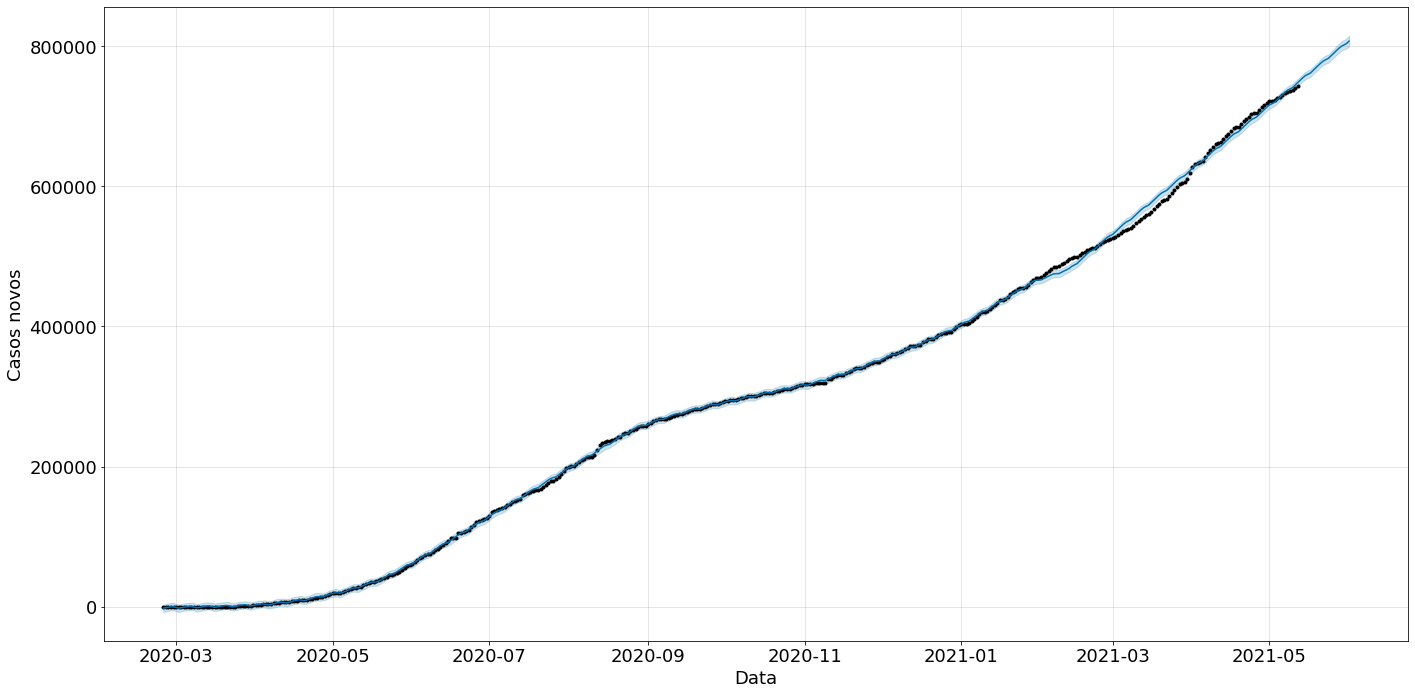

In [307]:
# em 'periods' indicamos o número interno de períodos a serem previstos.
dataframefuturo = modelo.make_future_dataframe(periods=20)
dataframefuturo.head()

# Prevendo os valores para o periodo selecionado
previsao = modelo.predict(dataframefuturo)
previsao.head()

# Gráfico da previsão acima
modelo.plot(previsao, xlabel='Data', ylabel='Casos novos', figsize=(20,10));

# **Referências**



1. https://blog.aaainovacao.com.br/crescimento-exponencial/
2. https://www.delftstack.com/pt/howto/python-pandas/how-to-filter-dataframe-rows-based-on-column-values-in-pandas/
3. https://stackoverflow.com/questions/9031783/hide-all-warnings-in-ipython
4. https://rdrr.io/cran/prophet/man/
5. https://rdrr.io/cran/prophet/man/make_future_dataframe.html